In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import cv2
import tqdm

In [2]:
import os, shutil, pathlib

In [3]:
IMAGE_SIZE = (150, 150, 3)

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    "train",
    seed=123,
    image_size=(150, 150),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    "test",
    seed=123,
    image_size=(150, 150),
    batch_size=32)

Found 1594 files belonging to 2 classes.
Found 394 files belonging to 2 classes.


In [5]:
class_names = train_dataset.class_names

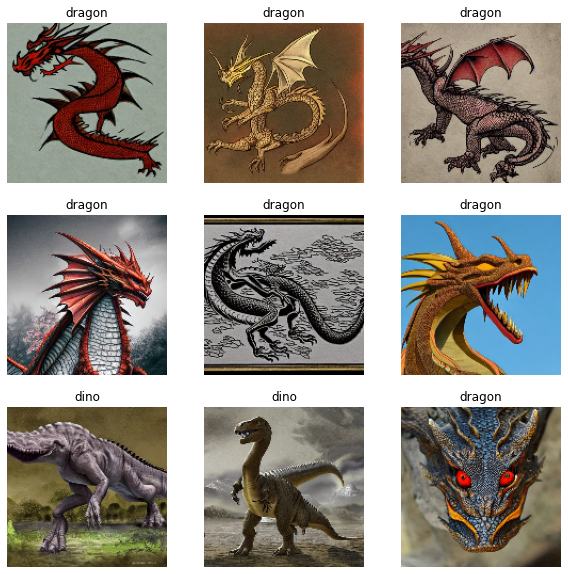

In [6]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))
 
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
train_dir = os.path.join(os.getcwd(),"train")

for class_, folder in zip(class_names, os.listdir(train_dir)):
    files_path = []
    for file in os.listdir(os.path.join(train_dir,folder)):
        files_path.append(file)
    print(f"class {class_}: {len(files_path)}")

class dino: 827
class dragon: 767


In [7]:
# assign class labels
class_labels = {class_name:i for i, class_name in enumerate(class_names)}
print(class_labels)

{'dino': 0, 'dragon': 1}


### Data Standardization (Not used for model fitting)

In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_train = train_dataset.map(lambda x, y: (normalization_layer(x), y))
normalized_validation = validation_dataset.map(lambda x, y: (normalization_layer(x), y))

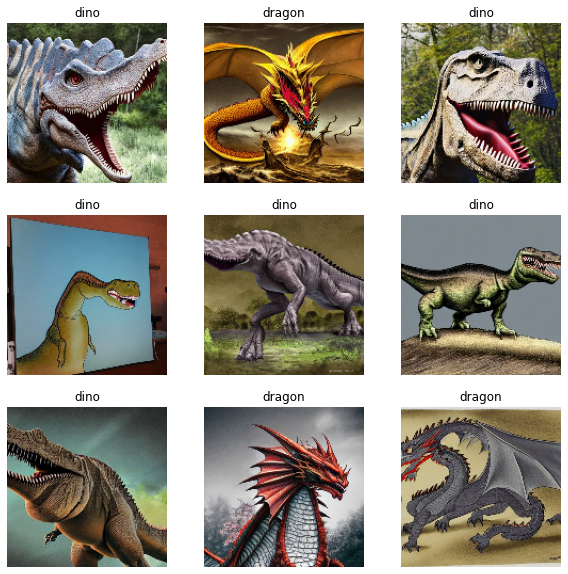

In [10]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))
 
for images, labels in normalized_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")

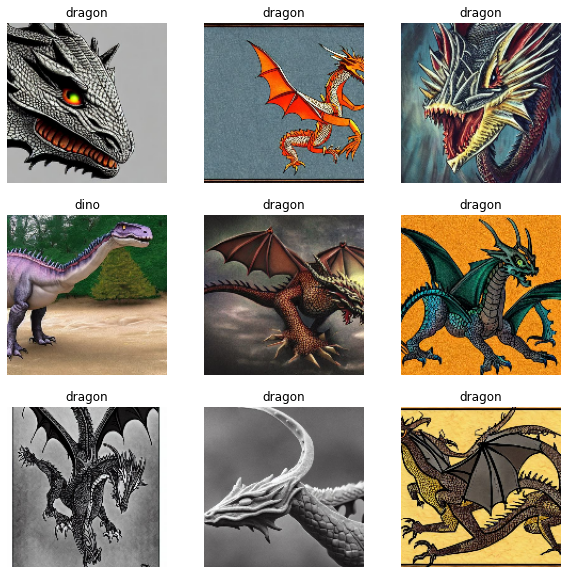

In [11]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))

for images, labels in normalized_validation.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
train_image_batch, train_labels_batch = next(iter(normalized_train))
val_image_batch, val_labels_batch = next(iter(normalized_validation))

first_image = train_image_batch[0]
second_image = val_image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
print(np.min(second_image), np.max(second_image))

0.0 1.0
0.0 0.99272007


### Building Neural Network Model from Scratch

Develop a CNN-based model with following structure:

- The shape for input should be `(150, 150, 3)`
- Next, create a convolutional layer (`Conv2D`):
    - Use 32 filters
    - Kernel size should be `(3, 3)` (that's the size of the filter)
    - Use `relu` as activation
- Reduce the size of the feature map with max pooling (`MaxPooling2D`)
    - Set the pooling size to `(2, 2)`
- Turn the multi-dimensional result into vectors using a `Flatten` layer
- Next, add a `Dense` layer with 64 neurons and '`relu`' activation
- Finally, create the `Dense` layer with 1 neuron - this will be the output
    - The output layer should have an activation - use the appropriate activation for the binary classification case

As optimizer use `SGD` with the following parameters:

    SGD(lr=0.002, momentum=0.8)


In [9]:
def make_model():

    inputs = keras.Input(shape=(150, 150, 3))
    conv_layer1 = layers.Conv2D(filters = 32, kernel_size=3, activation="relu")(inputs)  
    pool_layer1 = layers.MaxPooling2D(pool_size=2)(conv_layer1)
    flatten_layer = layers.Flatten()(pool_layer1)
    dense_layer = layers.Dense(64, activation="relu")(flatten_layer)
    outputs = layers.Dense(1, activation="sigmoid")(dense_layer)
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    optimizer = tf.keras.optimizers.SGD(
        learning_rate=0.002, momentum=0.8
    )
    loss = keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(optimizer=optimizer,
        loss=loss,
        metrics=["accuracy"])

    return model

In [10]:
model = make_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 64)                11214912  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                             

In [11]:
with tf.device("/device:GPU:0"):
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=10, batch_size=32
    )

Epoch 1/10
50/50 [==============================] - 17s 124ms/step - loss: 237.7620 - accuracy: 0.5301 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 2/10
50/50 [==============================] - 2s 38ms/step - loss: 0.6930 - accuracy: 0.5188 - val_loss: 0.6932 - val_accuracy: 0.4975
Epoch 3/10
50/50 [==============================] - 2s 34ms/step - loss: 0.6929 - accuracy: 0.5188 - val_loss: 0.6933 - val_accuracy: 0.4975
Epoch 4/10
50/50 [==============================] - 2s 41ms/step - loss: 0.6928 - accuracy: 0.5188 - val_loss: 0.6933 - val_accuracy: 0.4975
Epoch 5/10
50/50 [==============================] - 2s 39ms/step - loss: 0.6927 - accuracy: 0.5188 - val_loss: 0.6934 - val_accuracy: 0.4975
Epoch 6/10
50/50 [==============================] - 2s 39ms/step - loss: 0.6927 - accuracy: 0.5188 - val_loss: 0.6934 - val_accuracy: 0.4975
Epoch 7/10
50/50 [==============================] - 2s 36ms/step - loss: 0.6926 - accuracy: 0.5188 - val_loss: 0.6935 - val_accuracy: 0.4975
Epoch 8/1

In [12]:
X, y = next(iter(train_dataset))

In [13]:
y

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1])>

### Question 1

Since we have a binary classification problem, what is the best loss function for us?

#### Answer: binary crossentropy

Note: since we specify an activation for the output layer, we don't need to set from_logits=True

### Question 2

What's the total number of parameters of the model? You can use the summary method for that.

#### Answer: 11215873



### Generators and Training

For the next two questions, use the following data generator for both train and validation:
```
ImageDataGenerator(rescale=1./255)
```
- We don't need to do any additional pre-processing for the images.
- When reading the data from train/val directories, check the `class_mode` parameter. Which value should it be for a binary classification problem?
- Use `batch_size=20`
- Use `shuffle=True` for both training and validation


In [14]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

train_ds = train_gen.flow_from_directory(
    'train',
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    class_mode="sparse"
)

val_ds = val_gen.flow_from_directory(
    'test',
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    class_mode="sparse"
    
)

Found 1594 images belonging to 2 classes.
Found 394 images belonging to 2 classes.


In [15]:
X, y = next(train_ds)

In [16]:
X[:1]

array([[[[0.23137257, 0.5019608 , 0.1764706 ],
         [0.20000002, 0.4784314 , 0.10980393],
         [0.18431373, 0.4666667 , 0.07450981],
         ...,
         [0.27058825, 0.59607846, 0.18039216],
         [0.3372549 , 0.6627451 , 0.24705884],
         [0.3372549 , 0.6627451 , 0.24705884]],

        [[0.1137255 , 0.39607847, 0.07450981],
         [0.16078432, 0.44705886, 0.09803922],
         [0.3137255 , 0.6039216 , 0.23137257],
         ...,
         [0.4156863 , 0.7372549 , 0.3372549 ],
         [0.5058824 , 0.8313726 , 0.40784317],
         [0.3254902 , 0.654902  , 0.21568629]],

        [[0.15294118, 0.4431373 , 0.10196079],
         [0.19215688, 0.48235297, 0.14117648],
         [0.39607847, 0.6901961 , 0.33333334],
         ...,
         [0.4039216 , 0.7254902 , 0.33333334],
         [0.27450982, 0.6       , 0.1764706 ],
         [0.3647059 , 0.69411767, 0.24705884]],

        ...,

        [[0.427451  , 0.3803922 , 0.427451  ],
         [0.07058824, 0.03137255, 0.02745098]

In [17]:
y

array([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 1., 1.], dtype=float32)

In [18]:
history.epoch[-1] 

9

In [19]:
model_2 = make_model()

In [20]:
with tf.device("/device:GPU:0"):
    history2 = model_2.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
    )

Epoch 1/10
80/80 [==============================] - 8s 88ms/step - loss: 0.6906 - accuracy: 0.5521 - val_loss: 0.6896 - val_accuracy: 0.4975
Epoch 2/10
80/80 [==============================] - 7s 82ms/step - loss: 0.6461 - accuracy: 0.6455 - val_loss: 0.6042 - val_accuracy: 0.7360
Epoch 3/10
80/80 [==============================] - 7s 83ms/step - loss: 0.5490 - accuracy: 0.7535 - val_loss: 0.4905 - val_accuracy: 0.7893
Epoch 4/10
80/80 [==============================] - 7s 84ms/step - loss: 0.4610 - accuracy: 0.7967 - val_loss: 0.5010 - val_accuracy: 0.7411
Epoch 5/10
80/80 [==============================] - 7s 87ms/step - loss: 0.4038 - accuracy: 0.8275 - val_loss: 0.3775 - val_accuracy: 0.8629
Epoch 6/10
80/80 [==============================] - 7s 83ms/step - loss: 0.3450 - accuracy: 0.8632 - val_loss: 0.4128 - val_accuracy: 0.8173
Epoch 7/10
80/80 [==============================] - 7s 83ms/step - loss: 0.3180 - accuracy: 0.8701 - val_loss: 0.3611 - val_accuracy: 0.8426
Epoch 8/10
80

In [21]:
np.median(history2.history['accuracy'], axis=0)   

0.8453575968742371

In [22]:
np.std(history2.history['loss'])

0.15304973077832995

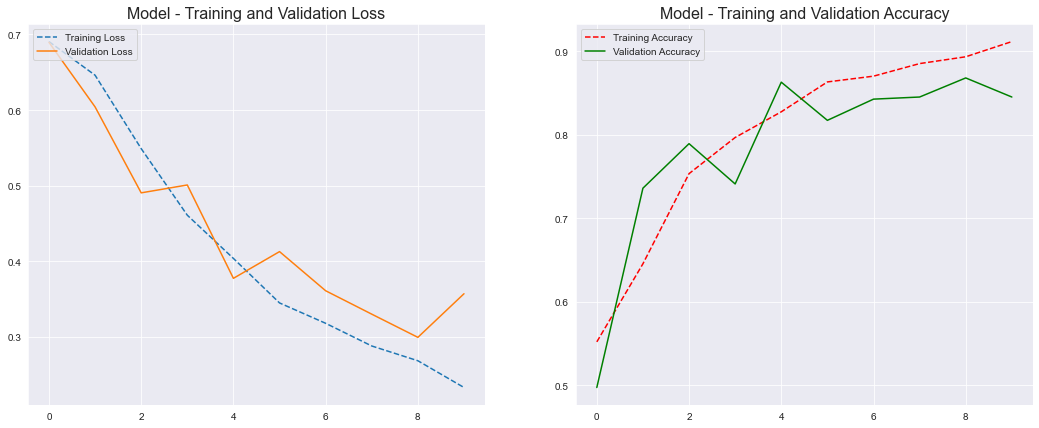

In [23]:
import seaborn as sns
sns.set_style('darkgrid')

## Generate visualization 
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,7))
ax1.plot(history2.history['loss'], label='Training Loss', linestyle="--")
ax1.plot(history2.history['val_loss'], label='Validation Loss')
ax1.set_title('Model - Training and Validation Loss', size=16)
ax1.legend(loc="upper left")
ax2.plot(history2.history['accuracy'], label='Training Accuracy', linestyle="--", color='r')
ax2.plot(history2.history['val_accuracy'], label='Validation Accuracy', color='g')
ax2.set_title('Model - Training and Validation Accuracy', size=16)
ax2.legend(loc="upper left")
plt.show()

### Question 3

What is the median of training accuracy for all the epochs for this model?

#### Answer: 0.84535 - > 0.90



### Question 4

What is the standard deviation of training loss for all the epochs for this model?

#### Answer: 0.15304 -> 0.11

### Data Augmentation

For the next two questions, we'll generate more data using data augmentations.

Add the following augmentations to your training data generator:

    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'


In [24]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [25]:
train_ds = train_gen.flow_from_directory(
    'train',
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    class_mode="sparse"
)

Found 1594 images belonging to 2 classes.


In [26]:
history2.epoch[-1] 

9

In [27]:
history2.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [28]:
with tf.device("/device:GPU:0"):
    history3 = model_2.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        initial_epoch=history2.epoch[-1]+1
    )

Epoch 11/20
80/80 [==============================] - 18s 219ms/step - loss: 0.4566 - accuracy: 0.7898 - val_loss: 0.3004 - val_accuracy: 0.8680
Epoch 12/20
80/80 [==============================] - 18s 226ms/step - loss: 0.4547 - accuracy: 0.7911 - val_loss: 0.4186 - val_accuracy: 0.7792
Epoch 13/20
80/80 [==============================] - 18s 227ms/step - loss: 0.4086 - accuracy: 0.8193 - val_loss: 0.4439 - val_accuracy: 0.7893
Epoch 14/20
80/80 [==============================] - 19s 238ms/step - loss: 0.3942 - accuracy: 0.8231 - val_loss: 0.2771 - val_accuracy: 0.8934
Epoch 15/20
80/80 [==============================] - 18s 227ms/step - loss: 0.3906 - accuracy: 0.8281 - val_loss: 0.3361 - val_accuracy: 0.8325
Epoch 16/20
80/80 [==============================] - 18s 227ms/step - loss: 0.3834 - accuracy: 0.8149 - val_loss: 0.4988 - val_accuracy: 0.7766
Epoch 17/20
80/80 [==============================] - 18s 220ms/step - loss: 0.3748 - accuracy: 0.8356 - val_loss: 0.3677 - val_accuracy:

In [29]:
history3.epoch

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

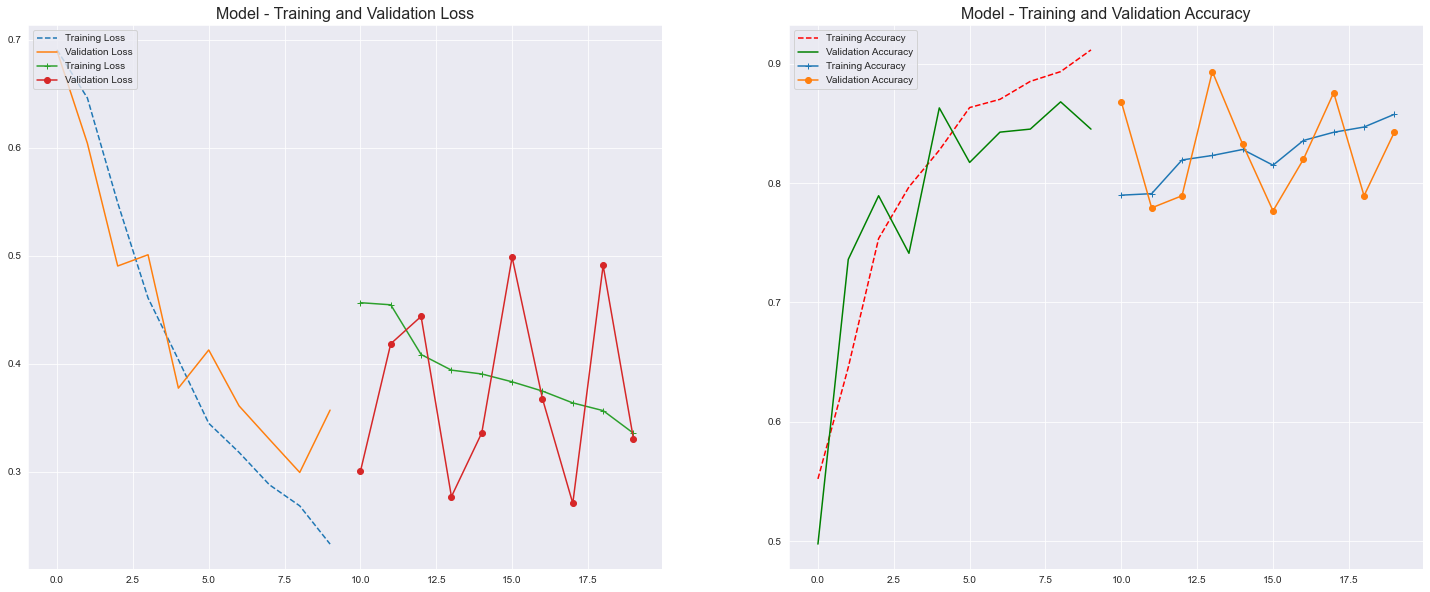

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25,10))
ax1.plot(history2.history['loss'], label='Training Loss', linestyle="--")
ax1.plot(history2.history['val_loss'], label='Validation Loss')
ax1.plot(history3.epoch, history3.history['loss'], label='Training Loss', marker='+')
ax1.plot(history3.epoch, history3.history['val_loss'], label='Validation Loss', marker='o')
ax1.set_title('Model - Training and Validation Loss', size=16)
ax1.legend(loc="upper left")
ax2.plot(history2.history['accuracy'], label='Training Accuracy', linestyle="--", color='r')
ax2.plot(history2.history['val_accuracy'], label='Validation Accuracy', color='g')
ax2.plot(history3.epoch, history3.history['accuracy'], label='Training Accuracy', marker='+')
ax2.plot(history3.epoch, history3.history['val_accuracy'], label='Validation Accuracy', marker='o')
ax2.set_title('Model - Training and Validation Accuracy', size=16)
ax2.legend(loc="upper left")
plt.show()

In [31]:
np.mean(history3.history['val_loss'], axis=0)   

0.37349621653556825

In [32]:
np.average(history3.history['val_accuracy'][5:10], axis=0)   

0.820812177658081

### Question 5

What is the mean of test loss for all the epochs for the model trained with augmentations?

#### Answer: 0.37349 -> 0.37



### Question 6

What's the average of test accuracy for the last 5 epochs (from 6 to 10) for the model trained with augmentations?
#### Answer: 0.82081 -> 0.84

### Testing Model Prediction (from 8.12)

In [33]:
from tensorflow.keras.preprocessing.image import load_img

path = './test/dragon/0967e534-cc4b-4e91-a995-3d2407bcf08a.jpg'
img = load_img(path, target_size=(150, 150))
x = np.array(img)
X = np.array([x])
X.shape

(1, 150, 150, 3)

In [34]:
pred = model_2.predict(X)

1/1 [==============================] - 0s 400ms/step


In [35]:
pred

array([[1.]], dtype=float32)

In [36]:
pred[0]

array([1.], dtype=float32)

In [37]:
pred[0][0]

1.0

In [38]:
train_ds.class_indices

{'dino': 0, 'dragon': 1}

In [39]:
val_ds.class_indices

{'dino': 0, 'dragon': 1}

In [40]:
dict_class = val_ds.class_indices

In [41]:
[k for k, v in dict_class.items() if v == 1][0]

'dragon'

### Beyond Homework

What would be done:
- Custom learning rate
- Custom callback
- Custom confusion matrix

In [15]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

train_ds = train_gen.flow_from_directory(
    'train',
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    class_mode="sparse"
)

val_ds = val_gen.flow_from_directory(
    'test',
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    class_mode="sparse"
    
)

Found 1594 images belonging to 2 classes.
Found 394 images belonging to 2 classes.


#### A) Custom Learning Rate

Exponential scheduling is defined with arguments of the current epoch and it returns the learning rate. As the epoch continues to raise, learning rate sees a decrease that reflects the exponential behaviour.

Read more: Hands-On Machine Learning with Scikit-Learn and Tensorflow, Chapter 11: Training Deep Neural Networks

In [16]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.002, s=15)

#### B) Custom callback

Keras provides means that take specific actions which are not included in built-in callbacks: this is done via subclassing the `keras.callbacks.Callback` class.

Read more: Deep Learning with Python, Chapter 7: Training Deep Neural Networks

In [17]:
from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                 label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []

#### C) Custom confusion matrix

Here showcased two ways of calculating classification performance.

Read here: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

In [18]:
### C.1 Using Keras Backend
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
### C.2 Using scikit-learn metrics
from sklearn.metrics import classification_report

y_pred = model.predict(x_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

In [19]:
def custom_model():

    inputs = keras.Input(shape=(150, 150, 3))
    conv_layer1 = layers.Conv2D(filters = 32, kernel_size=3, activation="relu")(inputs)  
    pool_layer1 = layers.MaxPooling2D(pool_size=2)(conv_layer1)
    flatten_layer = layers.Flatten()(pool_layer1)
    dense_layer = layers.Dense(64, activation="relu")(flatten_layer)
    outputs = layers.Dense(1, activation="sigmoid")(dense_layer)
    model = keras.Model(inputs=inputs, outputs=outputs)   

    return model

In [20]:
model_custom = custom_model()

optimizer = tf.keras.optimizers.SGD(
        learning_rate=0.002, momentum=0.8
    )
loss = keras.losses.BinaryCrossentropy(from_logits=False)

model_custom.compile(optimizer=optimizer,
    loss=loss,
    metrics=["accuracy", f1_m, precision_m, recall_m])

Epoch 1/45
80/80 [==============================] - 26s 199ms/step - loss: 0.5748 - accuracy: 0.6976 - f1_m: 0.6081 - precision_m: 0.6704 - recall_m: 0.6515 - val_loss: 0.5628 - val_accuracy: 0.6447 - val_f1_m: 0.4680 - val_precision_m: 0.9125 - val_recall_m: 0.3205 - lr: 0.0020
Epoch 2/45
80/80 [==============================] - 7s 93ms/step - loss: 0.4182 - accuracy: 0.8218 - f1_m: 0.7969 - precision_m: 0.8458 - recall_m: 0.7983 - val_loss: 0.3827 - val_accuracy: 0.8325 - val_f1_m: 0.8333 - val_precision_m: 0.7887 - val_recall_m: 0.8925 - lr: 0.0017
Epoch 3/45
80/80 [==============================] - 7s 92ms/step - loss: 0.3607 - accuracy: 0.8570 - f1_m: 0.8403 - precision_m: 0.8683 - recall_m: 0.8452 - val_loss: 0.3540 - val_accuracy: 0.8477 - val_f1_m: 0.8487 - val_precision_m: 0.8209 - val_recall_m: 0.8984 - lr: 0.0015
Epoch 4/45
80/80 [==============================] - 10s 118ms/step - loss: 0.3240 - accuracy: 0.8789 - f1_m: 0.8717 - precision_m: 0.8781 - recall_m: 0.8860 - val_l

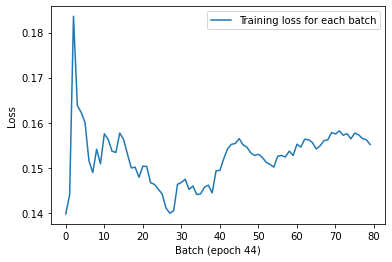

In [21]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("custom_model",
                                                         save_best_only=True)
with tf.device("/device:GPU:0"):
    history4 = model_custom.fit(
        train_ds,
        validation_data=val_ds,
        epochs=45,
        callbacks=[lr_scheduler, LossHistory()]
    )

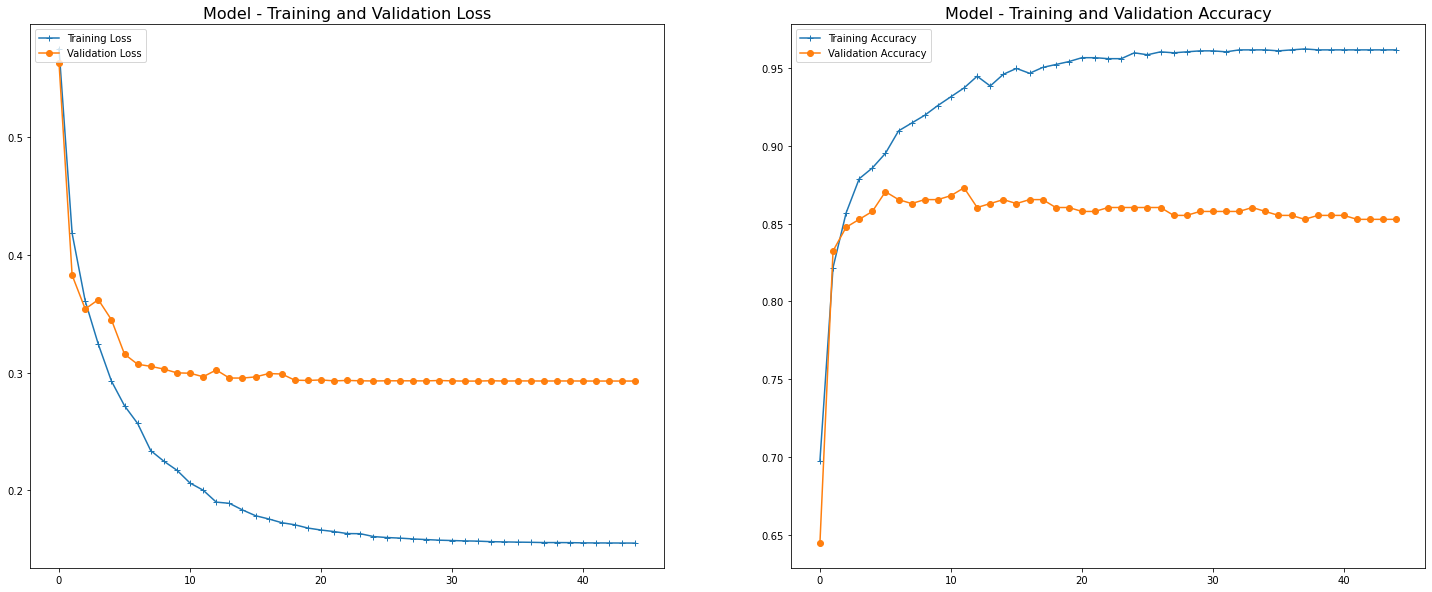

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25,10))

ax1.plot(history4.epoch, history4.history['loss'], label='Training Loss', marker='+')
ax1.plot(history4.epoch, history4.history['val_loss'], label='Validation Loss', marker='o')
ax1.set_title('Model - Training and Validation Loss', size=16)
ax1.legend(loc="upper left")
ax2.plot(history4.epoch, history4.history['accuracy'], label='Training Accuracy', marker='+')
ax2.plot(history4.epoch, history4.history['val_accuracy'], label='Validation Accuracy', marker='o')
ax2.set_title('Model - Training and Validation Accuracy', size=16)
ax2.legend(loc="upper left")
plt.show()

In [ ]:
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

In [54]:
from sklearn.metrics import classification_report

y_pred = model_custom.predict(val_ds, batch_size=20, verbose=1)

20/20 [==============================] - 1s 70ms/step


In [55]:
model_custom.evaluate(val_ds, batch_size=20, verbose=1)

20/20 [==============================] - 1s 66ms/step - loss: 0.2928 - accuracy: 0.8528 - f1_m: 0.8321 - precision_m: 0.8327 - recall_m: 0.8427


[0.2927801311016083,
 0.8527919054031372,
 0.8321331143379211,
 0.8326627016067505,
 0.842660129070282]

In [56]:
X, y = next(val_ds)
y

array([1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0.,
       1., 0., 0.], dtype=float32)

In [57]:
### Viewing representative labels over test_gen_pred
test_idx_to_cls = {v: k for k, v in val_ds.class_indices.items()}

### Replace integer class to string type 
test_ground_truth = np.vectorize(test_idx_to_cls.get)(val_ds.classes)

In [58]:
## Retrieve class with the largest predicted probability.
test_pred_idx = y_pred.argmax(axis=-1)
test_prediction = np.vectorize(test_idx_to_cls.get)(test_pred_idx)

In [61]:
test_ground_truth.shape

(394,)

In [62]:
test_prediction.shape

(394,)

In [63]:
print(classification_report(test_ground_truth, test_prediction, labels=['dino', 'dragon']))

              precision    recall  f1-score   support

        dino       0.50      1.00      0.66       196
      dragon       0.00      0.00      0.00       198

    accuracy                           0.50       394
   macro avg       0.25      0.50      0.33       394
weighted avg       0.25      0.50      0.33       394



C:\Users\rizdi\miniconda3\envs\tensorflow2_venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rizdi\miniconda3\envs\tensorflow2_venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rizdi\miniconda3\envs\tensorflow2_venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,